In [4]:
% matplotlib inline
import matplotlib.pyplot as plt
from __future__ import division
from gensim.models.wrappers import LdaMallet
import numpy as np
import pandas as pd
import gensim.corpora as corpora
import json
from gensim.models import CoherenceModel
from gensim.utils import SaveLoad

In [5]:
config = json.load(open('../config.json', 'r'))
MALLET = config['MALLET']
INPUT_DIR = config['INPUT_DIR']
OUTPUT_DIR = config['OUTPUT_DIR']
TWEET_DIR = config['TWEET_DIR']
NUM_TOPICS = config['NUM_CLUSTERS']
SEED = config['SEED']
events = open(INPUT_DIR + 'event_names.txt', 'r').read().splitlines()

## Get sample for computing topics

In [6]:
def get_samples():
    tweets = []
    event_names = []
    sample_indices = []
    for event in events:
        all_tweets = open(TWEET_DIR + event + '/' + event + '_cleaned_text.txt', 'r').read().splitlines()
        N = len(all_tweets)
        print(event, N)
        
        # get tweets with embeddings
        idx1 = np.load(TWEET_DIR + event + '/' + event + '_partisan_indices_among_cleaned_indices.npy')
        all_tweets = [all_tweets[i] for i in idx1]
        
        # get sample for determining topics
        idx2 = np.load(TWEET_DIR + event + '/' + event + '_indices_among_embeddings_for_getting_topics.npy')
        all_tweets = [all_tweets[i] for i in idx2]
        
        # get indices among cleaned ones
        filter1 = sorted(list(set(idx1) & set(range(N))))
        filter2 = [filter1[j] for j in idx2]
        sample_indices.extend(filter2)
        
        
        event_names.extend([event] * len(all_tweets))
        tweets.extend([t.split() for t in all_tweets])
    df = pd.DataFrame({'tweet': tweets, 'event': event_names, 'index_in_clean_text': sample_indices})
    return df

In [7]:
tweets = get_samples()

chattanooga 29550
roseburg 18042
colorado_springs 55792
san_bernardino 70452
kalamazoo 10950
orlando 1825759
dallas 259736
baton_rouge 46036
burlington 8148
fort_lauderdale 12514
fresno 8850
san_francisco 10484
vegas 1284855
thornton 14296
sutherland_springs 153889
parkland 272213
nashville 38638
santa_fe 73563
annapolis 27673
pittsburgh 59869
thousand_oaks 117580


In [8]:
tweets['tweet'].head()

0    [pray, for, the, citizen, of, after, a, domest...
1    [from, shoot, prais, god, we, re, aliv, if, yo...
2    [say, i, am, realli, realli, then, she, say, i...
3    [suspect, in, tennesse, shoot, was, natur, us,...
4    [when, the, murder, is, christian, the, attack...
Name: tweet, dtype: object

## run Mallet

In [12]:
# credits: https://www.machinelearningplus.com/nlp/topic-modeling-gensim-python/#16buildingldamalletmodel

In [9]:
texts = tweets['tweet']

# Create Dictionary
id2word = corpora.Dictionary(texts)

# Term Document Frequency
corpus = [id2word.doc2bow(t) for t in texts]

In [10]:
id2word.save(OUTPUT_DIR + 'ldamallet.dict')

In [11]:
print(corpus[:1])

[[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1), (9, 1), (10, 1), (11, 1)]]


In [12]:
ldamallet = LdaMallet(MALLET, corpus=corpus, num_topics=NUM_TOPICS, workers=4, id2word=id2word, iterations=1000, random_seed = SEED)

In [13]:
ldamallet.save(OUTPUT_DIR + 'ldamallet_model_' + str(NUM_TOPICS) + '.pickle')

In [14]:
ldamallet.show_topics(formatted=True)

[(0,
  '0.055*"polic" + 0.054*"shot" + 0.050*"dead" + 0.045*"shooter" + 0.038*"shoot" + 0.035*"report" + 0.035*"suspect" + 0.032*"offic" + 0.029*"news" + 0.022*"airport"'),
 (1,
  '0.106*"kill" + 0.064*"peopl" + 0.049*"shooter" + 0.046*"attack" + 0.040*"hous" + 0.035*"white" + 0.024*"terrorist" + 0.023*"plan" + 0.021*"man" + 0.020*"call"'),
 (2,
  '0.121*"gun" + 0.053*"school" + 0.032*"church" + 0.031*"high" + 0.023*"stop" + 0.020*"control" + 0.020*"law" + 0.019*"texa" + 0.016*"parkland" + 0.013*"student"'),
 (3,
  '0.080*"shoot" + 0.079*"victim" + 0.035*"famili" + 0.035*"san" + 0.034*"prayer" + 0.027*"today" + 0.026*"live" + 0.024*"anoth" + 0.023*"thought" + 0.022*"bernardino"'),
 (4,
  '0.027*"trump" + 0.023*"don" + 0.019*"happen" + 0.018*"whi" + 0.018*"time" + 0.016*"make" + 0.015*"obama" + 0.013*"becaus" + 0.012*"america" + 0.012*"blame"'),
 (5,
  '0.190*"shoot" + 0.043*"mass" + 0.033*"vega" + 0.027*"gunman" + 0.025*"orlando" + 0.022*"thousand" + 0.021*"las" + 0.019*"massacr" + 0.0

In [15]:
keywords_mapper = {i: ", ".join([word for word, prop in ldamallet.show_topic(i)]) for i in range(ldamallet.num_topics)}

In [16]:
with open(OUTPUT_DIR + 'mallet_' + str(NUM_TOPICS) + '_words.json', 'w') as f:
    f.write(json.dumps(keywords_mapper))

In [17]:
coherence_model_ldamallet = CoherenceModel(model=ldamallet, texts=texts, dictionary=id2word, coherence='c_v')
coherence_ldamallet = coherence_model_ldamallet.get_coherence()
print('\nCoherence Score: ', coherence_ldamallet)


Coherence Score:  0.4287694000446977


## get most dominant topics for each tweet

In [33]:
ldamallet[corpus[0]]   # this takes forever to run, so you have to run it on the whole corpus at once

[(0, 0.16091954022988506),
 (1, 0.16091954022988506),
 (2, 0.14367816091954025),
 (3, 0.14559386973180077),
 (4, 0.1532567049808429),
 (5, 0.23563218390804594)]

In [ ]:
# load
id2word = SaveLoad.load(OUTPUT_DIR + 'ldamallet.dict')
ldamallet = SaveLoad.load(OUTPUT_DIR + 'ldamallet_model_' + str(NUM_TOPICS) + '.pickle')

In [18]:
def get_topic_assignments(event):
    print(event)
    
    # get tweets for which we have embeddings
    tweets = open(TWEET_DIR + event + '/' + event + '_cleaned_text.txt', 'r').read().splitlines()
    idx1 = np.load(TWEET_DIR + event + '/' + event + '_partisan_indices_among_cleaned_indices.npy')
    tweets = [tweets[i] for i in idx1]
    
    # get indices of these tweets in the original data
    original_indices = np.load(TWEET_DIR + event + '/' + event + '_cleaned_and_partisan_indices.npy')
    
    # get topics
    corpus = [id2word.doc2bow(t.split()) for t in tweets]
    pred_topics = ldamallet[corpus]
    
    dicts = []
    for row in pred_topics:
        d = {}
        for i, (topic, prob) in enumerate(sorted(row, key=lambda x: (x[1]), reverse=True)):
            d['topic_' + str(i)] = topic  # ith closest topic
            d['prob_' + str(i)] = prob  # probability of ith closest topic
        dicts.append(d)
    df = pd.DataFrame(dicts)
    df['indices_in_original'] = original_indices
    df.to_csv(TWEET_DIR + event + '/' + event + '_mallet_topics_' + str(NUM_TOPICS) + '.csv', index=False)

In [19]:
for event in events:
    get_topic_assignments(event)

chattanooga
roseburg
colorado_springs
san_bernardino
kalamazoo
orlando
dallas
baton_rouge
burlington
fort_lauderdale
fresno
san_francisco
vegas
thornton
sutherland_springs
parkland
nashville
santa_fe
annapolis
pittsburgh
thousand_oaks


## get the topics for the docs that LdaMallet was trained on

In [68]:
top_topic = []
top_perc = []
for i, t in enumerate(ldamallet.load_document_topics()):
    topic, perc = sorted(t, key=lambda x: (x[1]), reverse=True)[0]
    top_topic.append(topic)
    top_perc.append(perc)

In [74]:
tweets['topic_no'] = top_topic
tweets['top_perc'] = top_perc
tweets['topic_words'] = tweets['topic_no'].map(keywords_mapper)

(array([1.1996e+04, 3.8299e+04, 5.1286e+04, 3.1692e+04, 2.4731e+04,
        1.4578e+04, 8.5270e+03, 5.3660e+03, 2.1770e+03, 1.1570e+03,
        6.0000e+02, 2.4000e+02, 1.1200e+02, 5.0000e+01, 2.3000e+01,
        1.5000e+01, 2.0000e+00, 1.0000e+00, 1.0000e+00, 2.0000e+00]),
 array([0.16666667, 0.17986891, 0.19307116, 0.20627341, 0.21947566,
        0.2326779 , 0.24588015, 0.2590824 , 0.27228464, 0.28548689,
        0.29868914, 0.31189139, 0.32509363, 0.33829588, 0.35149813,
        0.36470037, 0.37790262, 0.39110487, 0.40430712, 0.41750936,
        0.43071161]),
 <a list of 20 Patch objects>)

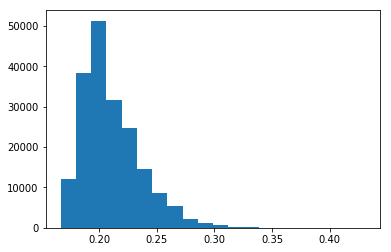

In [78]:
plt.hist(tweets['top_perc'], bins=20)

In [80]:
# most representative tweet for each topic
for i, g in tweets.groupby(['topic_words']):
    print(i)
    print(g.sort_values('top_perc', ascending = False).tweet[:20])
    print('---------')

gun, school, church, high, law, control, texa, parkland, violenc, student
143835    [aurora, gun, free, zone, orlando, gun, free, ...
135022    [high, school, februari, dougla, high, school,...
134246    [sandi, hook, gun, free, zone, puls, nightclub...
151848    [shooter, in, stole, gun, from, his, dad, tx, ...
151368    [run, on, the, hot, topic, of, gun, control, t...
154696    [i, didn, t, propos, to, lock, up, law, abid, ...
159444    [texa, gun, law, no, background, check, no, no...
157612    [univers, background, check, it, s, too, easi,...
135936    [yesterday, fl, suffer, an, horrif, tragedi, i...
140271    [i, ve, been, a, teacher, at, a, high, school,...
6268      [gun, free, zone, #sandyhook, gun, free, zone,...
132498    [whi, not, just, a, ban, on, gun, a, univers, ...
131326    [gun, obsess, cruz, was, abl, to, easili, purc...
131371    [a, texa, high, school, teacher, is, on, leav,...
137767    [to, everi, year, old, student, at, dougla, hi...
126307    [too, mani, gun,

## sample tweets for MTurk evaluation

In [ ]:
# sample an equal number of tweets from each event
sample_size = 20
20 * 21